# Artificial Neural Networks and Deep Learning - Homework 2


## 🌐 Connect Colab to Google Drive

In [1]:
#from google.colab import drive

#drive.mount("/gdrive")
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2024-12-09 12:48:42.827990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 12:48:42.867863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 12:48:42.879527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 12:48:42.907306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 12:48:44.569358: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0
Keras version: 3.4.1
GPU devices: 1


I0000 00:00:1733744928.523748  180700 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733744928.613106  180700 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733744928.614638  180700 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# Set the mixed precision policy to use float16 (half precision)
policy = tfk.mixed_precision.Policy('mixed_float16')
tfk.mixed_precision.set_global_policy(policy)

## ⏳ Load and prepare the Data

In [4]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [6]:
# Remove outliers (containing aliens)
outliers = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# Print the new shape
print(f"Training X shape after outlier removal: {X_train.shape}")
print(f"Training y shape after outlier removal: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape after outlier removal: (2505, 64, 128, 1)
Training y shape after outlier removal: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [7]:
# Map all non-4 labels into label 0. and 4 labels into 1
for i, label in enumerate(y_train):
    y_train[i] = np.where(label == 4.0, 1, 0)

num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

Number of classes: 2


In [8]:
# Count the number of images containing a pixel with a given label
counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        counts[int(value)] += 1
for label, count in enumerate(counts):
    print(f"Number of images containing label {int(label)}: {count}")

Number of images containing label 0: 2505
Number of images containing label 1: 63


In [9]:
no_big_rock = []
for i, labels in enumerate(y_train):
    label_list = np.unique(labels)
    if 1.0 not in label_list:
        no_big_rock.append(i)

In [10]:
# Remove images with no label 1
X_train = np.delete(X_train, no_big_rock, axis=0)
y_train = np.delete(y_train, no_big_rock, axis=0)

In [11]:
# Count the number of images containing a pixel with a given label
counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        counts[int(value)] += 1
for label, count in enumerate(counts):
    print(f"Number of images containing label {int(label)}: {count}")

Number of images containing label 0: 63
Number of images containing label 1: 63


In [12]:
# Count the number of pixels with a given label
label_list, counts = np.unique(y_train, return_counts=True)
for label, count in zip(label_list, counts):
    print(f"Number of pixels with label {int(label)}: {count}")
class_weights = {i: sum(counts) / counts[i] for i in range(num_classes)}
print("Class weights: " + str(class_weights))

Number of pixels with label 0: 489133
Number of pixels with label 1: 26963
Class weights: {0: 1.0551240664604515, 1: 19.14089678448244}


In [13]:
# Split into training and validation (80-20)
val_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=seed, test_size=val_size
)

In [14]:
# Check imbalance between training and validation
train_counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        train_counts[int(value)] += 1

val_counts = [0 for _ in range(num_classes)]
for labels in y_val:
    label_list = np.unique(labels)
    for value in label_list:
        val_counts[int(value)] += 1

ratios = [val_counts[i] / train_counts[i] / val_size for i in range(num_classes)]

for i in range(num_classes):
    print(f"Ratio of images containing a label in validation vs train compared to ideal split for label {i}: {ratios[i]}")

Ratio of images containing a label in validation vs train compared to ideal split for label 0: 1.3
Ratio of images containing a label in validation vs train compared to ideal split for label 1: 1.3


In [15]:
category_map = {
    0: 0, # other
    1: 1  # big rock
}

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )
    return table.lookup(label)

In [16]:
@tf.function
def random_flip_h(image, label):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label

@tf.function
def random_flip_v(image, label):
    """Consistent random vertical flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(label), lambda: label
    )
    return image, label

@tf.function
def random_brightness(image):
    delta = tf.random.uniform([])
    delta_thresh = 0.1
    image = tf.cond(
        delta < 3*delta_thresh, lambda: tf.image.adjust_brightness(image, delta=delta), lambda: image
    )
    return image

@tf.function
def random_contrast(image):
    factor = tf.random.uniform([])
    factor_thresh = 2
    image = tf.cond(
        factor < factor_thresh/6, lambda: tf.image.adjust_contrast(image, contrast_factor=factor), lambda: image
    )
    return image

@tf.function
def augmentation(image, label, seed=None):
    image, label = random_flip_h(image, label)
    #image, label = random_flip_v(image, label)
    #image = random_brightness(image)
    #image = random_contrast(image)
    return image, label

In [17]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Add an axis to labels
    new_labels = labels[..., np.newaxis]

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, new_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [18]:
batch_size = 32

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train,
    y_train.astype("int32"),
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed,
)

val_dataset = make_dataset(
    X_val, y_val.astype("int32"), batch_size=batch_size, shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...


I0000 00:00:1733744934.411288  180700 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733744934.413373  180700 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733744934.415145  180700 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733744934.636580  180700 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Analyze the data

Visualizing examples from the training set:


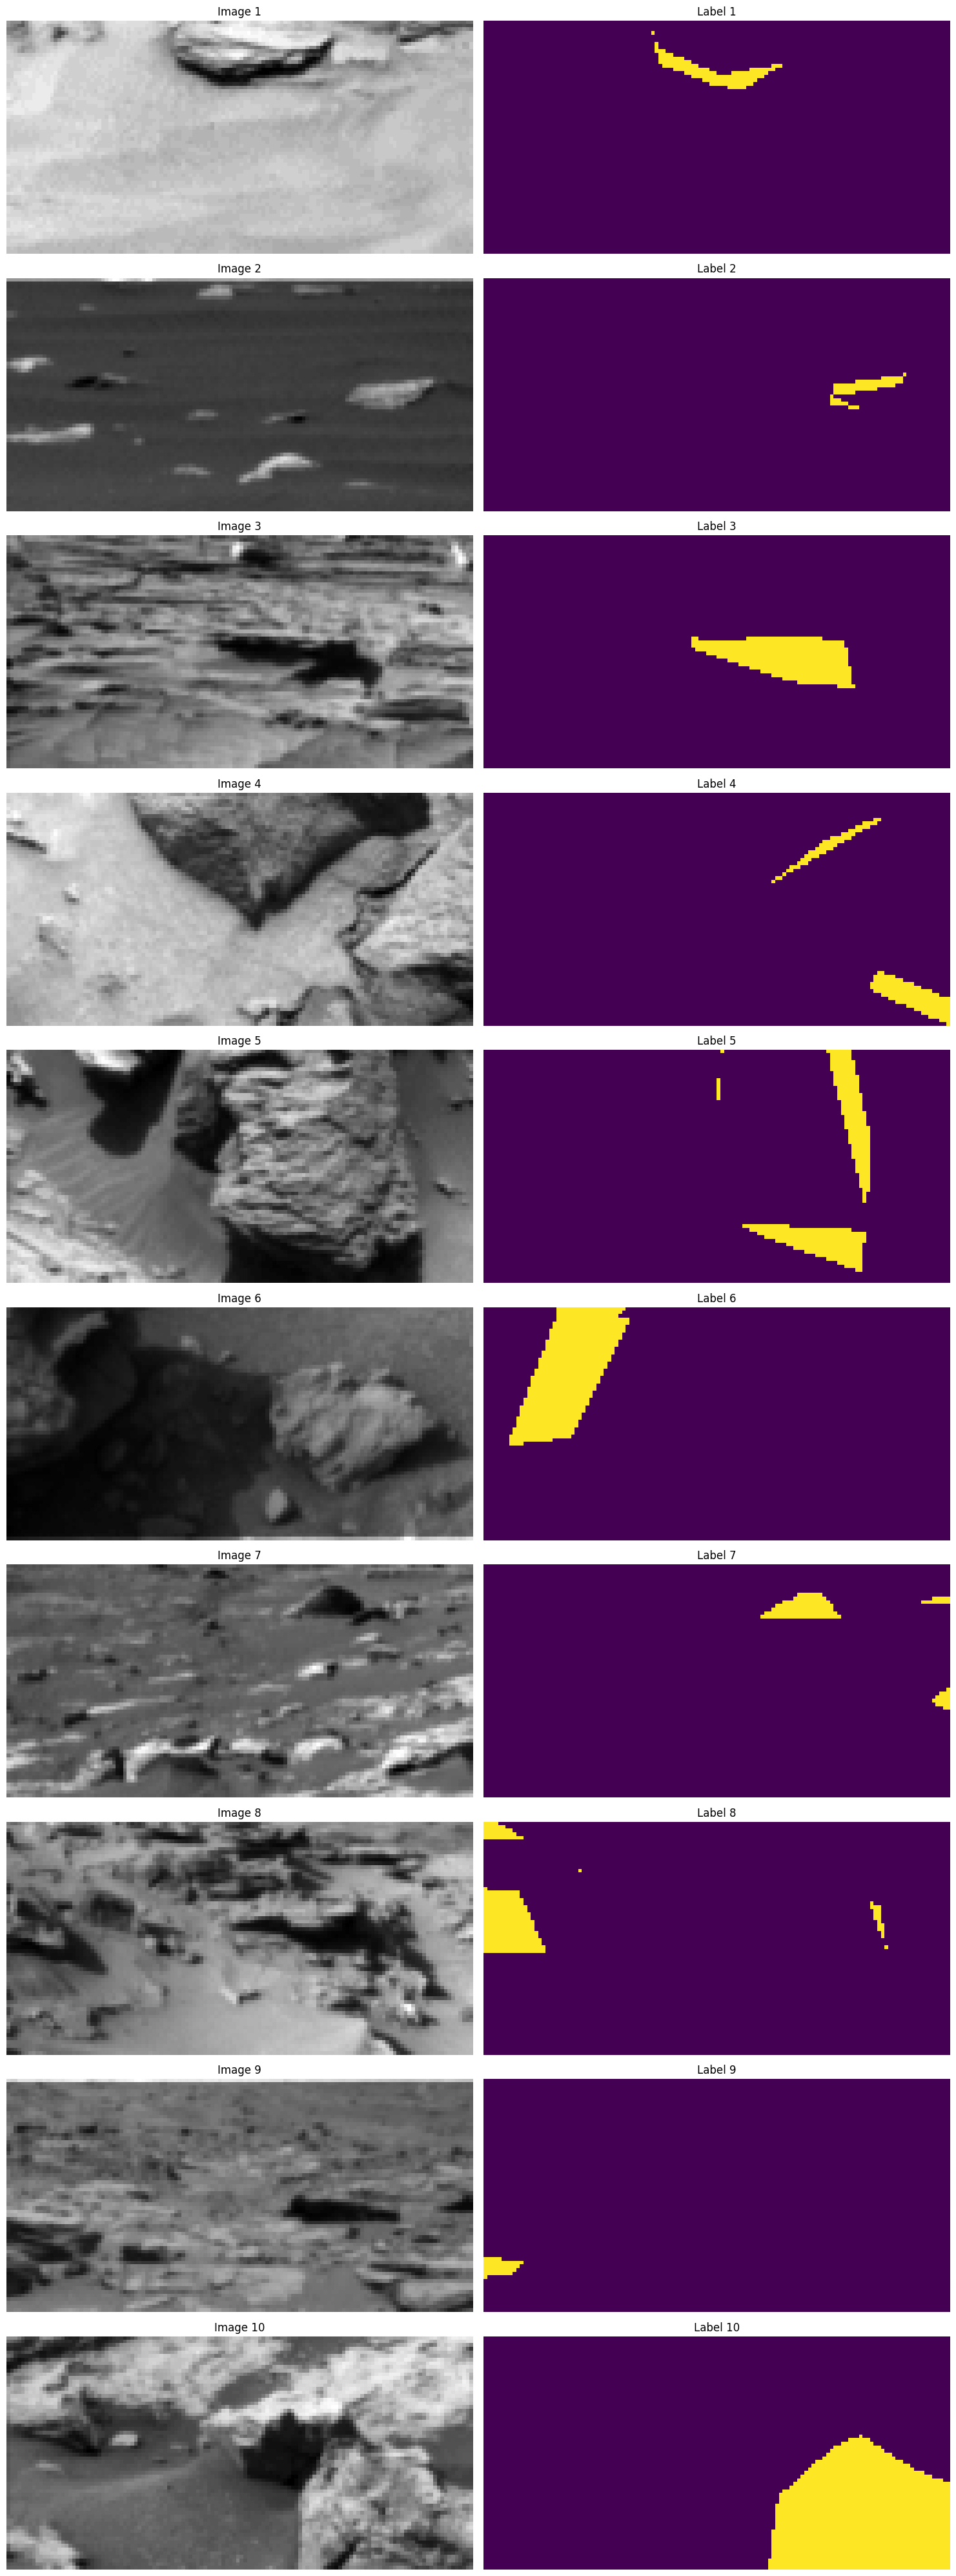

In [19]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def plot_sample_batch(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(images))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(images[j], cmap="grey")
        plt.title(f"Image {j+1}")
        plt.axis("off")

        # Plot colored label
        plt.subplot(num_samples, 2, j * 2 + 2)
        colored_label = apply_colormap(labels[j], colormap)
        plt.imshow(colored_label)
        plt.title(f"Label {j+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

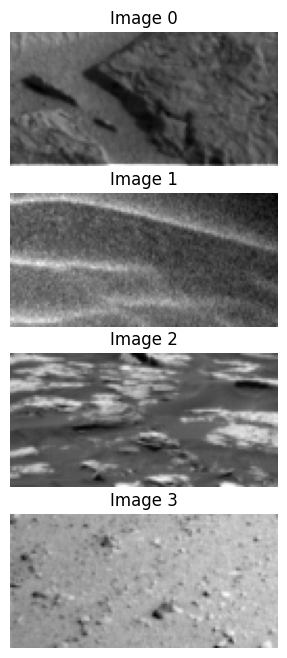

In [20]:
# Visualize examples from the test set.
num_samples = 4
plt.figure(figsize=(15, 2 * num_samples))

colormap = create_segmentation_colormap(num_classes)

for j in range(min(num_samples, len(X_test))):
    plt.subplot(num_samples, 1, j + 1)
    plt.imshow(X_test[j], cmap="grey")
    plt.title(f"Image {j}")
    plt.axis("off")

## 🛠️ Define the model

In [21]:
def unet_block(
    input_tensor, filters, kernel_size=3, activation="relu", stack=2, name=""
):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding="same",
            name=name + "conv" + str(i + 1),
        )(x)
        x = tfkl.BatchNormalization(name=name + "bn" + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + "activation" + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [22]:
# Define a Residual block with configurable parameters (currently unused, but
# used in older models). Note that a modified version of this block is used in
# the final model, by combining it with the inception block.
def residual_unet_block(x, filters, kernel_size=3, padding='same',
                        downsample=False, activation='relu', stack=2, name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # First convolutional block with Batch Normalisation and activation.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [23]:
# Define the Inception block with batch normalization (BN) and with multiple
# convolution paths and optional downsampling.
def inception_block_bn(x, filters, padding='same',
                       downsample=False, activation='relu', stack=2, name='inception'):
    # This inception block consists of a 1x1 convolution path, a 3x3 convolution
    # path, a 5x5 convolution path, and a pooling path. The paths are then
    # concatenated to form the final block output.
    # The reason for using multiple paths is to allow the model to learn
    # different features at different scales, and to increase the model's
    # capacity without increasing the number of parameters too much.
    # The downsampling (pooling) is not mandatory.

    # Loop through specified stack layers for multiple inception paths.
    for s in range(stack):
        # 1x1 convolution path with batch normalization and activation.
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)

        # 3x3 convolution path with initial reduction layer.
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        conv3_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(conv3_reduce)
        conv3_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(conv3_reduce)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)

        # 5x5 convolution path with initial reduction layer.
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        conv5_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(conv5_reduce)
        conv5_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(conv5_reduce)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)

        # Pooling path with projection for spatial dimensionality reduction.
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(pool_proj)

        # Concatenate all paths to form the final block output.
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [24]:
# Define the a residual block using an inception block instead of the
# convolutional path. This mixed block is used in the final model, and it
# combines the benefits of both residual and inception blocks. We believe
# that the residual and inception blocks are complementary, as their guesses
# don't seem to perfectly overlap. See the report for more details.
def inception_residual_unet(x, filters, padding='same', downsample=False,
                            activation='relu', stack=4, inception_stack=1,
                            name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # Create the inception block.
        x = inception_block_bn(x, filters, padding, downsample=False, activation=activation,
                               stack=inception_stack, name=f'{name}_inception_{s}')

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [25]:
def attention_gate(input_tensor, gating_tensor, inter_channels):
    # 1x1 convolution on the input (skip connection)
    theta_x = tfkl.Conv2D(inter_channels, kernel_size=1, strides=2, padding='same')(input_tensor)
    # 1x1 convolution on the gating (decoder output)
    phi_g = tfkl.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(gating_tensor)
    # Add and apply ReLU
    add = tfkl.Add()([theta_x, phi_g])
    relu = tfkl.Activation('relu')(add)
    # Generate attention weights
    psi = tfkl.Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu)
    # Upsample attention weights to match input_tensor spatial dimensions
    upsampled_psi = tfkl.UpSampling2D()(psi)
    # Multiply input tensor by attention weights
    output = tfkl.Multiply()([input_tensor, upsampled_psi])
    return output

In [26]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Downsampling path
    down_block_1 = inception_residual_unet(input_layer, 96, name="down_block1_")
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = inception_residual_unet(d1, 192, name="down_block2_")
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = inception_residual_unet(d2, 384, name="bottleneck")

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    attention_1 = attention_gate(down_block_2, bottleneck, 192)
    u1 = tfkl.Concatenate()([u1, attention_1])
    u1 = inception_residual_unet(u1, 192, name="up_block1_")

    u2 = tfkl.UpSampling2D()(u1)
    attention_2 = attention_gate(down_block_1, u1, 96)
    u2 = tfkl.Concatenate()([u2, attention_2])
    u2 = inception_residual_unet(u2, 96, name="up_block2_")

    # Output Layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation="softmax",
        name="output_layer",
    )(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="UNet")
    return model

In [27]:
# Define parameters
epochs = 1000
patience = 20
learning_rate = 1e-4

In [28]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
try:
    tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)
except:
    print("Model too complex to plot!")

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        24 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        16 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        32 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Activation)      │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   -   │
│ (Activation)      │ 8)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ input_layer[0… │   -   │
│ (MaxPooling2D)    │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │     2,616 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │     4,824 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        48 │ down_block1__… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │        96 │ down_block1__… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1__inc… │ (None, 64, 128, │         0 │ down_block1__… │   - 

 Total params: 1,839,016 (7.02 MB)

 Trainable params: 1,827,816 (6.97 MB)

 Non-trainable params: 11,200 (43.75 KB)

"dot" with args ['-Tpng', '/tmp/tmp_dmdq4xz/tmp2wn0kqa5'] returned code: -6

stdout, stderr:
 b''
b"failed at node 19393[0]\ndot: maze.c:311: chkSgraph: Assertion `np->cells[0]' failed.\n"

Model too complex to plot!


## Train the model

In [29]:
# Define custom Mean Intersection Over Union metric
@tfk.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(
        self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None
    ):
        super(MeanIntersectionOverUnion, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            label = apply_category_mapping(label)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="grey")
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
from tensorflow.keras import backend as K

from tensorflow.keras import backend as K

def iou_loss(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) loss.
    :param y_true: Ground truth tensor (not one-hot encoded).
    :param y_pred: Predicted tensor (probabilities or logits).
    :param smooth: Smoothing factor to avoid division by zero.
    :return: IoU loss value.
    """
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Initialize a list to store IoU values for each class (ignoring class 0)
    iou_values = []

    # Loop over all classes (excluding class 0)
    for i in range(1, num_classes):  # Start from 1 to exclude background (class 0)
        # Get the probabilities for the current class (class i)
        y_pred_class = y_pred[..., i]
        y_true_class = y_true_one_hot[..., i]

        # Flatten the predicted probabilities and true labels for class i
        y_true_f_class = K.flatten(y_true_class)
        y_pred_f_class = K.flatten(y_pred_class)

        # Calculate intersection and union for class i
        intersection = K.sum(y_true_f_class * y_pred_f_class)
        union = K.sum(y_true_f_class) + K.sum(y_pred_f_class) - intersection

        # Compute IoU for this class
        iou_class = (intersection + smooth) / (union + smooth)
        iou_values.append(iou_class)

    # Compute the mean IoU over all classes (excluding class 0)
    mean_iou = K.mean(K.stack(iou_values))

    # Return mean IoU loss (1 - mean IoU)
    return 1 - mean_iou

In [31]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=custom_loss,
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=[
        "accuracy",
        MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
    ],
)
print("Model compiled!")

Compiling model...
Model compiled!


In [32]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_iou", mode="max", patience=patience, restore_best_weights=True
)

image, label = val_dataset.take(1).get_single_element()
viz_callback = VizCallback(image[11:12, ...], label[11:12, ...])

reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=patience / 2, factor=0.2, min_lr=learning_rate / 100
)

callbacks = [early_stopping, viz_callback, reduce_lr_callback]

Epoch 1/1000


I0000 00:00:1733745086.060067  181043 service.cc:146] XLA service 0x73ed5000db30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733745086.060098  181043 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-09 12:51:34.622278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 12:51:57.360471: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-09 12:52:30.152042: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{} for conv (f16[24,1,1,96]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,64,128,96]{3,2,1,0}, f16[32,64,128,24]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cu

1/2 ━━━━━━━━━━━━━━━━━━━━ 5:03 303s/step - accuracy: 0.1335 - loss: 199.0514 - mean_iou: 0.3563

2024-12-09 12:55:10.080569: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[96,1,1,288]{3,2,1,0}, u8[0]{0}) custom-call(f16[18,64,128,288]{3,2,1,0}, f16[18,64,128,96]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-12-09 12:55:13.848501: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.768026307s
Trying algorithm eng0{} for conv (f16[96,1,1,288]{3,2,1,0}, u8[0]{0}) custom-call(f16[18,64,128,288]{3,2,1,0}, f16[18,64,128,96]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135s/step - accuracy: 0.1345 - loss: 183.8569 - mean_iou: 0.3643  

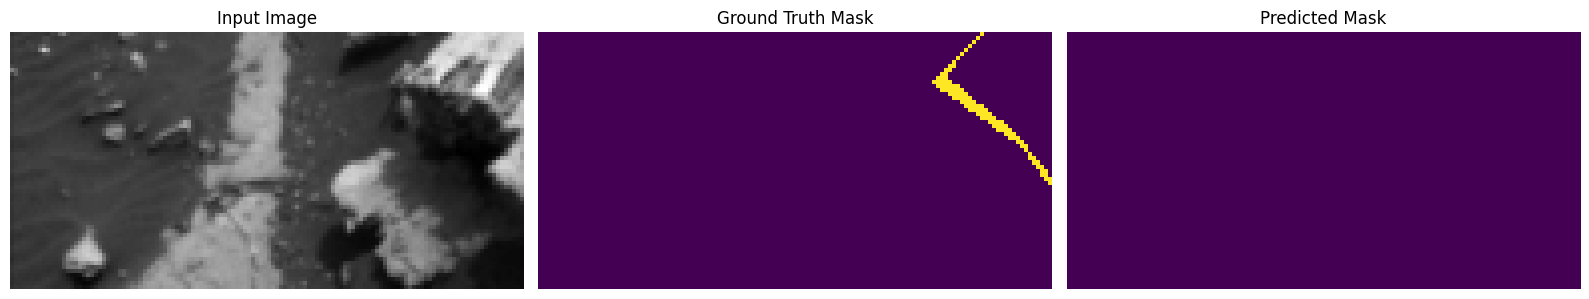

2/2 ━━━━━━━━━━━━━━━━━━━━ 481s 178s/step - accuracy: 0.1349 - loss: 178.7921 - mean_iou: 0.3670 - val_accuracy: 0.9541 - val_loss: 0.0236 - val_mean_iou: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - accuracy: 0.1371 - loss: 178.6451 - mean_iou: 0.3652 - val_accuracy: 0.9541 - val_loss: 1.5296 - val_mean_iou: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.1374 - loss: 179.6379 - mean_iou: 0.3749 - val_accuracy: 0.9541 - val_loss: 9.1009 - val_mean_iou: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - accuracy: 0.1922 - loss: 168.3351 - mean_iou: 0.3275 - val_accuracy: 0.9538 - val_loss: 21.5829 - val_mean_iou: 0.0022 - learning_rate: 1.0000e-04
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.3111 - loss: 147.4303 - mean_iou: 0.3153 - val_accuracy: 0.9387 - val_loss: 27.9411 - val_mean_iou: 0.0098 - learning_rate: 1.0000e-0

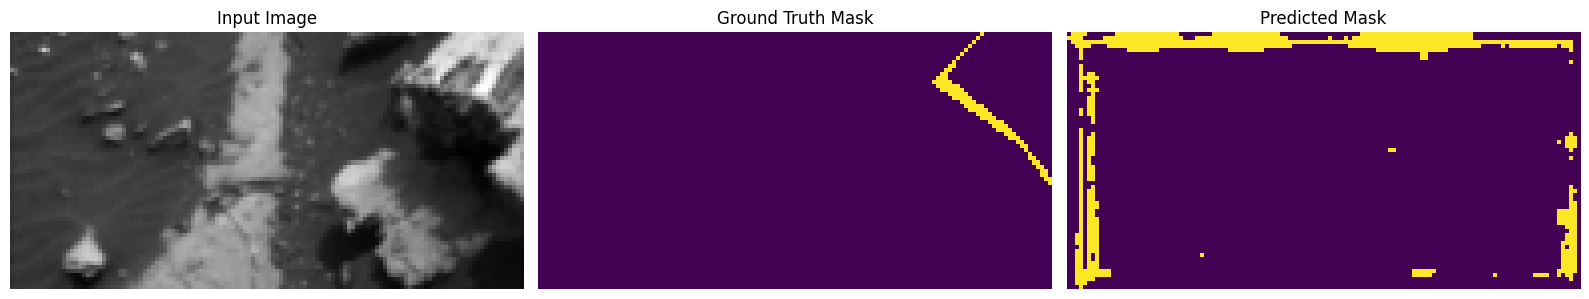

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3934 - loss: 131.4848 - mean_iou: 0.3166 - val_accuracy: 0.9125 - val_loss: 34.8394 - val_mean_iou: 0.0205 - learning_rate: 1.0000e-04
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - accuracy: 0.4816 - loss: 112.6110 - mean_iou: 0.3227 - val_accuracy: 0.7901 - val_loss: 43.7808 - val_mean_iou: 0.0496 - learning_rate: 1.0000e-04
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - accuracy: 0.5350 - loss: 102.8490 - mean_iou: 0.3247 - val_accuracy: 0.3545 - val_loss: 53.9807 - val_mean_iou: 0.2669 - learning_rate: 1.0000e-04
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.5932 - loss: 92.2392 - mean_iou: 0.3131 - val_accuracy: 0.1205 - val_loss: 63.6908 - val_mean_iou: 0.4369 - learning_rate: 1.0000e-04
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step - accuracy: 0.6588 - loss: 78.8773 - mean_iou: 0.3000 - val_accuracy: 0.0775 - val_loss: 71.9477 - val_mean_iou: 0.4606 - learning_rate: 1.0000e-04
Epoch 11/100

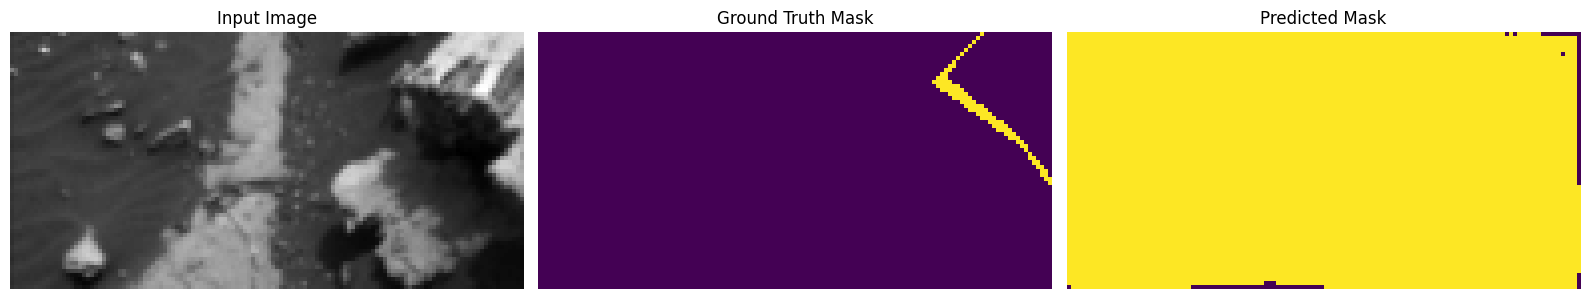

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7346 - loss: 62.4019 - mean_iou: 0.2673 - val_accuracy: 0.0679 - val_loss: 77.9692 - val_mean_iou: 0.4737 - learning_rate: 1.0000e-04
Epoch 12/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.7887 - loss: 50.2496 - mean_iou: 0.1888 - val_accuracy: 0.0854 - val_loss: 70.9025 - val_mean_iou: 0.4598 - learning_rate: 2.0000e-05
Epoch 13/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - accuracy: 0.7861 - loss: 52.6233 - mean_iou: 0.2094 - val_accuracy: 0.1478 - val_loss: 63.1735 - val_mean_iou: 0.4189 - learning_rate: 2.0000e-05
Epoch 14/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.8134 - loss: 46.2879 - mean_iou: 0.1913 - val_accuracy: 0.2997 - val_loss: 55.6710 - val_mean_iou: 0.3538 - learning_rate: 2.0000e-05
Epoch 15/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.8356 - loss: 39.8100 - mean_iou: 0.1881 - val_accuracy: 0.5613 - val_loss: 48.2461 - val_mean_iou: 0.2040 - learning_rate: 2.0000e-05
Epoch 16/100

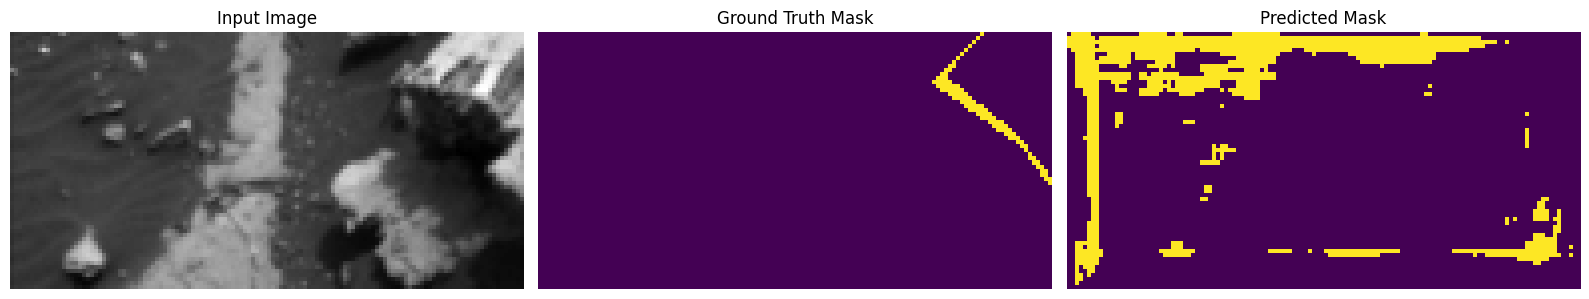

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step - accuracy: 0.8456 - loss: 37.9085 - mean_iou: 0.1775 - val_accuracy: 0.8103 - val_loss: 41.6309 - val_mean_iou: 0.0531 - learning_rate: 2.0000e-05
Epoch 17/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.8561 - loss: 37.0616 - mean_iou: 0.1487 - val_accuracy: 0.9163 - val_loss: 35.2558 - val_mean_iou: 0.0198 - learning_rate: 2.0000e-05
Epoch 18/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - accuracy: 0.8673 - loss: 33.8370 - mean_iou: 0.1590 - val_accuracy: 0.9440 - val_loss: 29.4394 - val_mean_iou: 0.0074 - learning_rate: 2.0000e-05
Epoch 19/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.8646 - loss: 36.5299 - mean_iou: 0.1545 - val_accuracy: 0.9538 - val_loss: 24.0589 - val_mean_iou: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 20/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.8920 - loss: 28.8797 - mean_iou: 0.1518 - val_accuracy: 0.9541 - val_loss: 20.1142 - val_mean_iou: 0.0000e+00 - learning_rate: 2.0000e-05
E

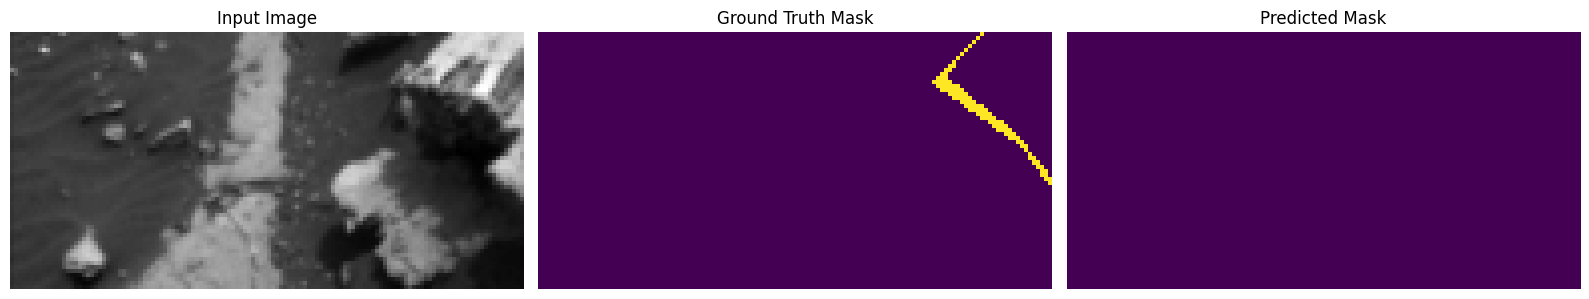

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 0.8917 - loss: 26.7716 - mean_iou: 0.1325 - val_accuracy: 0.9541 - val_loss: 17.3606 - val_mean_iou: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 22/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.8978 - loss: 24.6703 - mean_iou: 0.1168 - val_accuracy: 0.9541 - val_loss: 14.8856 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Epoch 23/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.8968 - loss: 23.8901 - mean_iou: 0.1077 - val_accuracy: 0.9541 - val_loss: 13.0002 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Epoch 24/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.9039 - loss: 25.8397 - mean_iou: 0.1109 - val_accuracy: 0.9541 - val_loss: 11.6490 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Epoch 25/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.9009 - loss: 25.3925 - mean_iou: 0.1165 - val_accuracy: 0.9541 - val_loss: 10.6751 - val_mean_iou: 0.0000e+00 - learning_rate: 

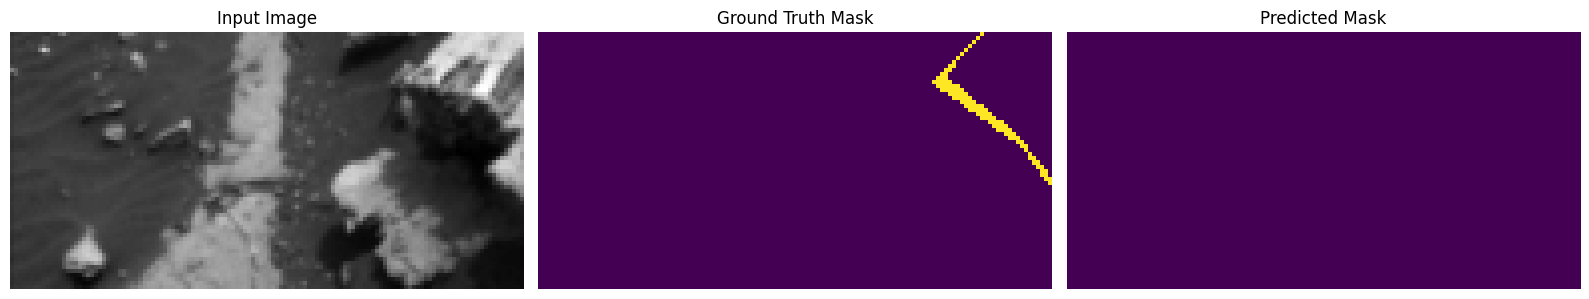

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step - accuracy: 0.9016 - loss: 25.2049 - mean_iou: 0.1087 - val_accuracy: 0.9541 - val_loss: 9.9350 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Epoch 27/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.8983 - loss: 27.1694 - mean_iou: 0.0956 - val_accuracy: 0.9541 - val_loss: 9.3936 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Epoch 28/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.8983 - loss: 23.3437 - mean_iou: 0.1002 - val_accuracy: 0.9541 - val_loss: 8.9263 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Epoch 29/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.9089 - loss: 24.0066 - mean_iou: 0.1147 - val_accuracy: 0.9541 - val_loss: 8.5075 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Epoch 30/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.9139 - loss: 22.8123 - mean_iou: 0.1244 - val_accuracy: 0.9541 - val_loss: 8.1193 - val_mean_iou: 0.0000e+00 - learning_rate: 4.000

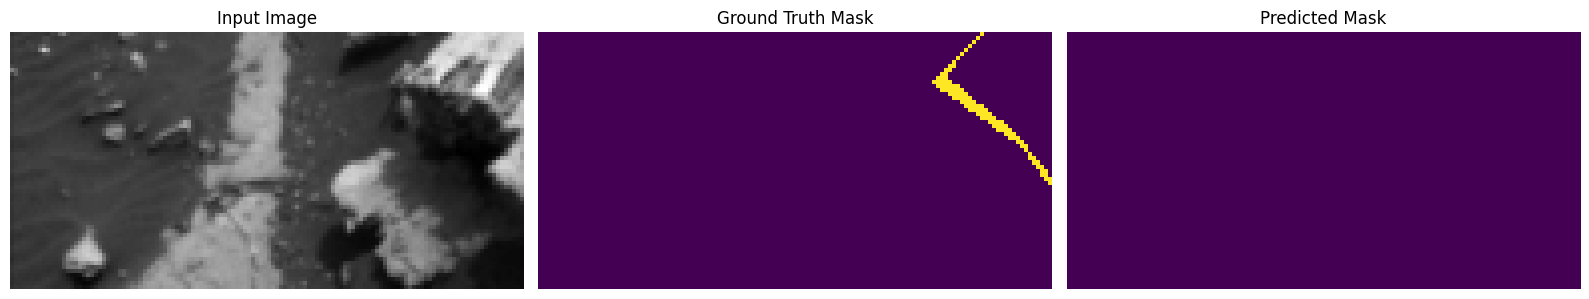

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - accuracy: 0.9103 - loss: 23.1281 - mean_iou: 0.1094 - val_accuracy: 0.9541 - val_loss: 7.7298 - val_mean_iou: 0.0000e+00 - learning_rate: 4.0000e-06
Final validation mean IoU: 47.37%


In [33]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_iou = round(max(history["val_mean_iou"]) * 100, 2)
print(f"Final validation mean IoU: {final_val_iou}%")   

In [34]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241209_125733.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [35]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241209_125733.keras


In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

def print_confusion(model):
    # Predict class probabilities and get predicted classes on the validation set.
    test_predictions = np.argmax(model.predict(X_val), axis=-1).flatten()

    # Extract ground truth classes.
    test_gt = y_val.flatten()

    # Calculate and display test set accuracy.
    test_accuracy = accuracy_score(test_gt, test_predictions)
    print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

    # Calculate and display test set precision.
    test_precision = precision_score(test_gt, test_predictions, average='weighted')
    print(f'Precision score over the test set: {round(test_precision, 4)}')

    # Calculate and display test set recall.
    test_recall = recall_score(test_gt, test_predictions, average='weighted')
    print(f'Recall score over the test set: {round(test_recall, 4)}')

    # Calculate and display test set F1 score.
    test_f1 = f1_score(test_gt, test_predictions, average='weighted')
    print(f'F1 score over the test set: {round(test_f1, 4)}')

    # Compute the confusion matrix.
    cm = confusion_matrix(test_gt, test_predictions)

    # Create labels combining confusion matrix values.
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    # Plot the confusion matrix with class labels.
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=range(num_classes), yticklabels=range(num_classes), cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Accuracy score over the test set: 0.0679
Precision score over the test set: 0.8702
Recall score over the test set: 0.0679
F1 score over the test set: 0.0513


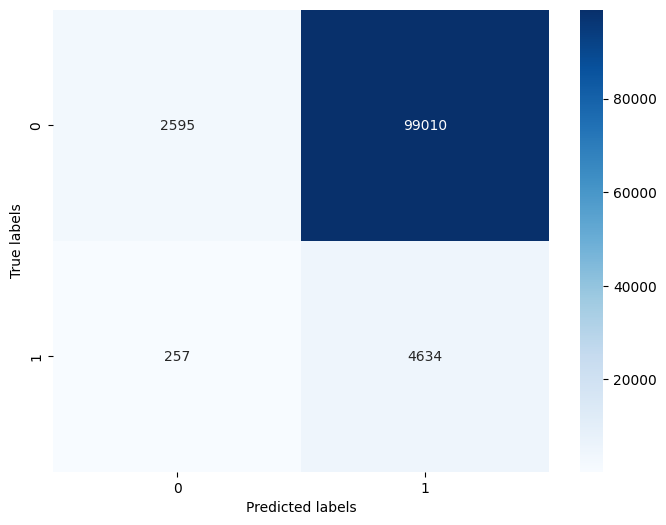

In [37]:
print_confusion(model)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```